In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint, entropy
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

from ipynb.fs.full.UtilFunctions import format_season
from ipynb.fs.full.UtilCollections import POSITIONS

In [3]:
def pre_process(seasons):
    df = None
    for season in seasons:
        per_min_cols = ['FGA', '3PA', '2PA', 'PF', 'PTS', 'OWS', 'DWS', 'OBPM', 'DBPM', 'BPM']
        cols_to_drop = None
        first_year, second_year = format_season(season)
        player_data = pd.read_csv(f"DataCollection/Player_Stats/player_stats_{first_year}-{second_year}.csv")
        if season > 1997:
            cols_to_drop = ['index', 'TRB', 'DRB', 'ORB', 'AST', 'G', 'GS', '2PAr', 'FT', 'FG', 'FG%', 'BLK', 'STL', 'Dunks', 
                                  'Heaves', 'HeavesAttempted', 'WS', 'FTA', 'TOV', 'Age', '2P', '3P', 'VORP']
            shooting_data = pd.read_csv(f"DataCollection/Player_Shooting_Stats/Regular_Season/player_shooting_stats_{first_year}-{second_year}.csv")
            player_data = pd.merge(player_data, shooting_data.loc[:,~shooting_data.columns.isin(['Pos', 'Age', 'G', 'MP', 'FG%', "3PAr", "2P%", "3P%"])], on=['Player', 'Tm'])

        else:
            cols_to_drop = ['index', 'TRB', 'DRB', 'ORB', 'AST', 'G', 'GS', 'FT', 'FG', 'FG%', 'BLK', 'STL',
                                'WS', 'FTA', 'TOV', 'Age', '2P', '3P', 'VORP']
            
        player_data = player_data.fillna(0)
        player_data = player_data[(player_data["MP"] > 15) & (player_data["G"] >= 30)]
        player_data = player_data.sort_values(by=['G'], ascending=False)
        player_data = player_data[player_data["Tm"] != "TOT"]
        player_data = player_data.drop_duplicates(subset ="Player",keep = "first")
        player_data.reset_index(inplace=True)
        player_data.drop(columns=cols_to_drop, inplace=True)
        
        for col in per_min_cols:
            player_data[col] = player_data[col] / player_data['MP'] * 36
        
        if df is None:
            df = player_data
        else:
            df = pd.concat([df, player_data])
            
    df.reset_index(inplace=True)
    df.drop('index', axis=1, inplace=True)
    return df

In [4]:
#teste de normalizar features
def random_forest_classify(X_train, y_train):
    rf = RandomForestClassifier()
    rand_search = RandomizedSearchCV(rf, param_distributions = {'n_estimators': randint(50,500), 'max_depth': randint(1, 20)},
                                 n_iter = 5, cv = 5, random_state=42)
    rand_search.fit(X_train, y_train)
    return rand_search.best_estimator_

In [5]:
def plot_feature_importances(importances, estimators, features):
    fi = pd.Series(importances, index=features).sort_values(ascending=False)
    #std = np.std([tree.feature_importances_ for tree in estimators], axis=0)
    fig, ax = plt.subplots(figsize=(18, 18))
    ax.bar(fi.index, fi)
    ax.tick_params('x', labelrotation=90)
    ax.set_title("Feature importances using MDI")
    ax.set_ylabel("Mean decrease in impurity")

In [6]:
def calculate_probability_matrix(cm):
    prob_matrix = []
    for i in range(len(cm)):
        prob_matrix.append([])
        players_in_position = sum(cm[i,:])
        for j in range(len(cm)):
            prob_matrix[i].append(round(cm[i,j]/players_in_position, 2))
    
    return prob_matrix

In [7]:
def plot_entropy_heatmap(entropies):
    sns.heatmap(entropies, cmap='coolwarm')

In [8]:
def entropy_by_position(positions, p_matrix):
    entropies = {}
    i = 0
    for position in positions:
        entropies[position] = entropy(p_matrix[i])
        i += 1
    return entropies

In [9]:
def plot_entropies_bar(entropies):
    plt.bar(range(len(entropies)), entropies.values(), label=POSITIONS)
    plt.xticks(range(len(POSITIONS)), POSITIONS)

## Pre-processing - gathering data from the last 6 seasons

In [10]:
df = pre_process(range(2017, 2023))

## Feature selection, splitting into training/testing

In [11]:
features = df.loc[:, ~df.columns.isin(["Player", "Pos", "Tm"])]
target = df['Pos']

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.2, random_state=42)

## Randomly select better parameters for Random Forest and fit the data

In [12]:
rf = random_forest_classify(X_train, y_train)

In [13]:
y_pred = rf.predict(X_test)

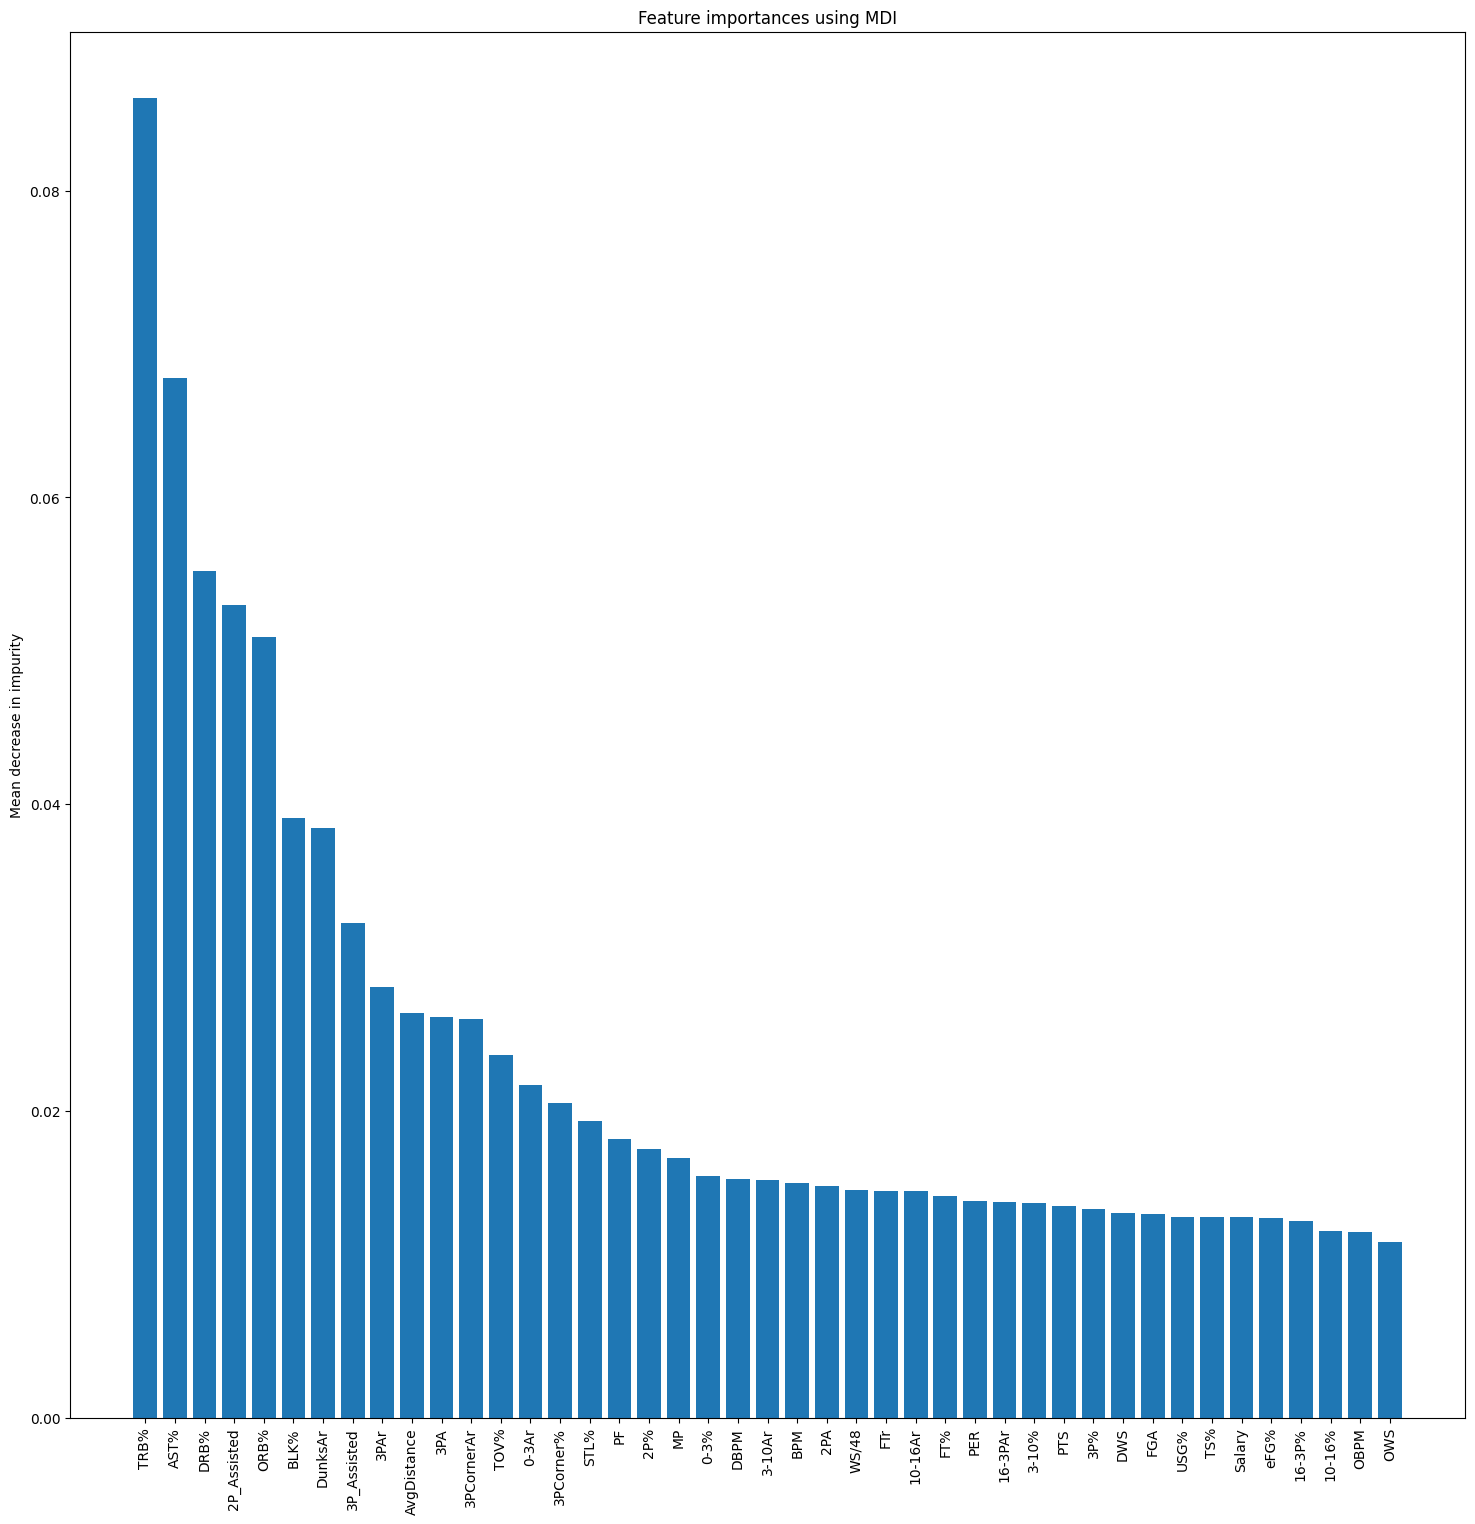

In [14]:
plot_feature_importances(rf.feature_importances_, rf.estimators_, [c for c in df.columns if c not in ['Player', 'Pos', 'Tm']])

In [15]:
fi = rf.feature_importances_

## Evaluating Random Forest results with Confusion Matrix and accuracy score

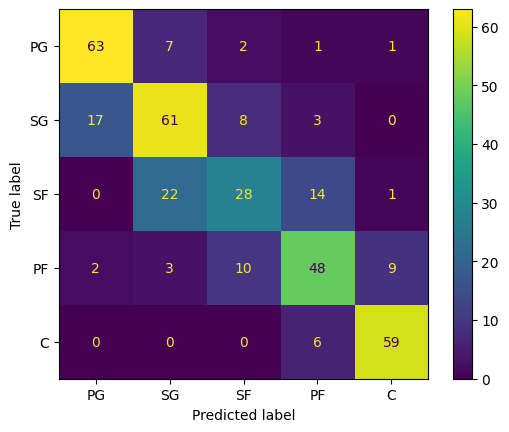

In [18]:
labels = ["PG", "SG", "SF", "PF", "C"]
cm = confusion_matrix(y_test, y_pred, labels=labels)
ConfusionMatrixDisplay(cm, display_labels=labels).plot()

In [17]:
accuracy_score(y_test, y_pred)

0.7095890410958904

In [17]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           C       0.88      0.91      0.89        65
          PF       0.72      0.69      0.71        72
          PG       0.79      0.85      0.82        74
          SF       0.61      0.58      0.60        65
          SG       0.68      0.66      0.67        89

    accuracy                           0.74       365
   macro avg       0.74      0.74      0.74       365
weighted avg       0.73      0.74      0.74       365



In [18]:
prob_matrix = calculate_probability_matrix(cm)

In [19]:
entropies_df = pd.DataFrame()

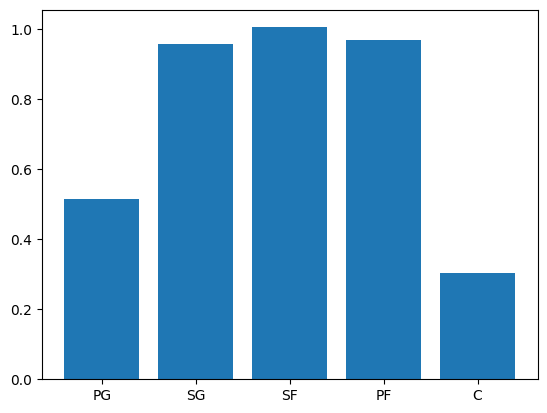

In [20]:
entropies = entropy_by_position(POSITIONS, prob_matrix)
plot_entropies_bar(entropies)
entropies_df['Mod_Mod'] = entropies

## Visualize trees from random forest with Graphviz

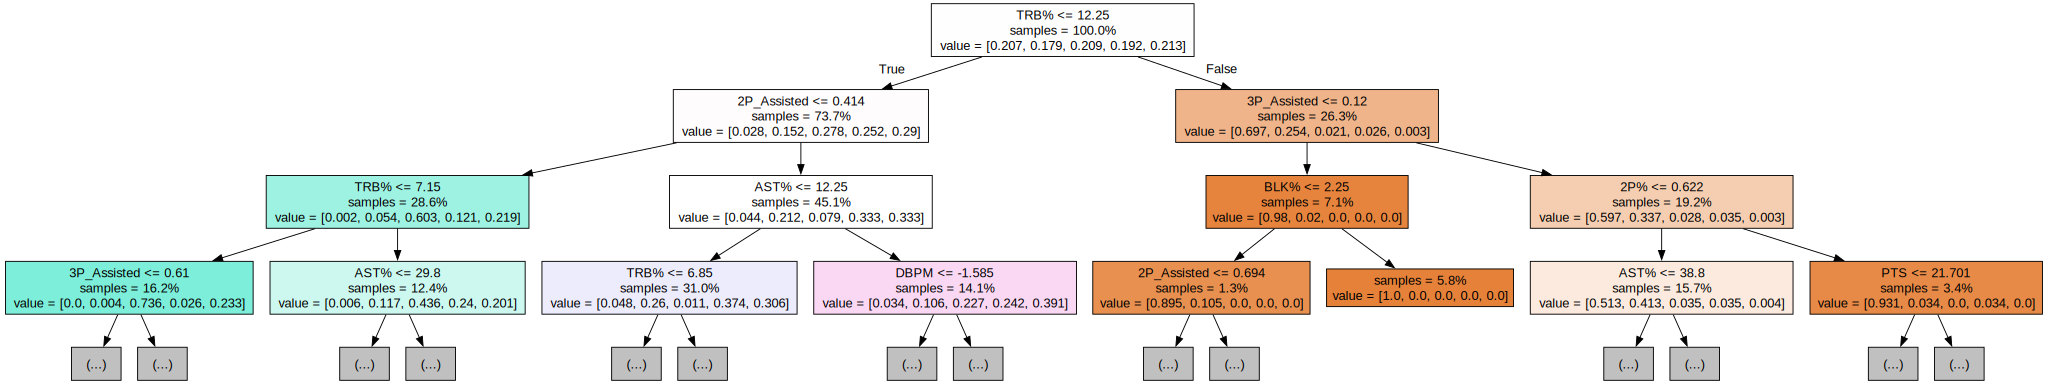

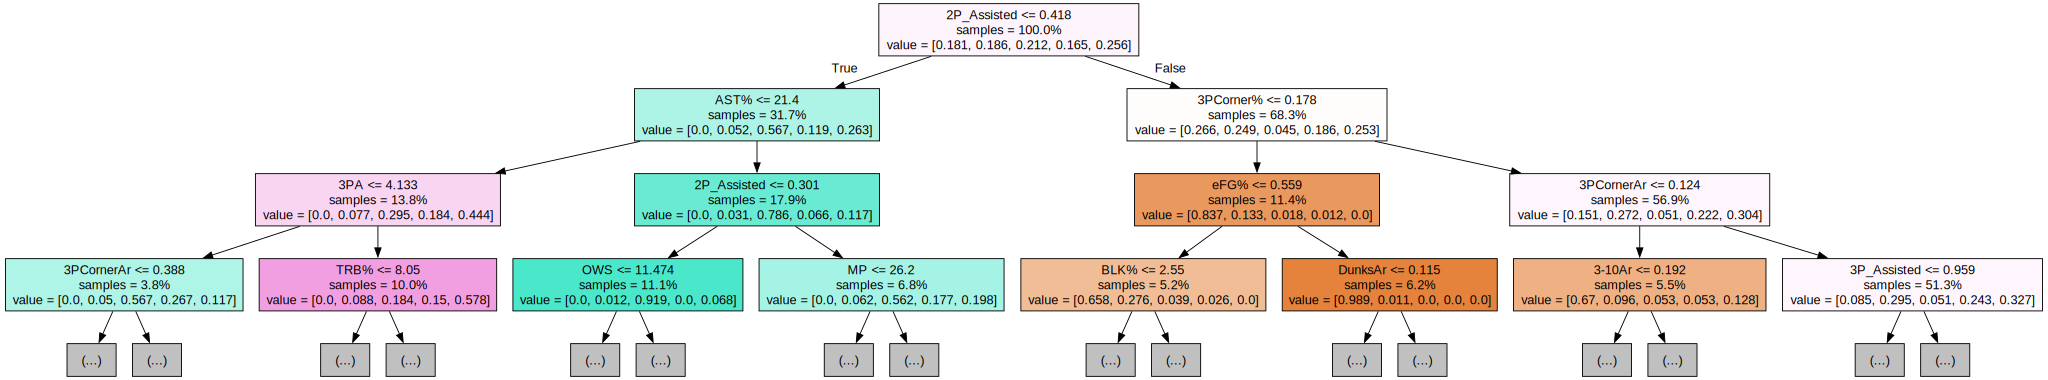

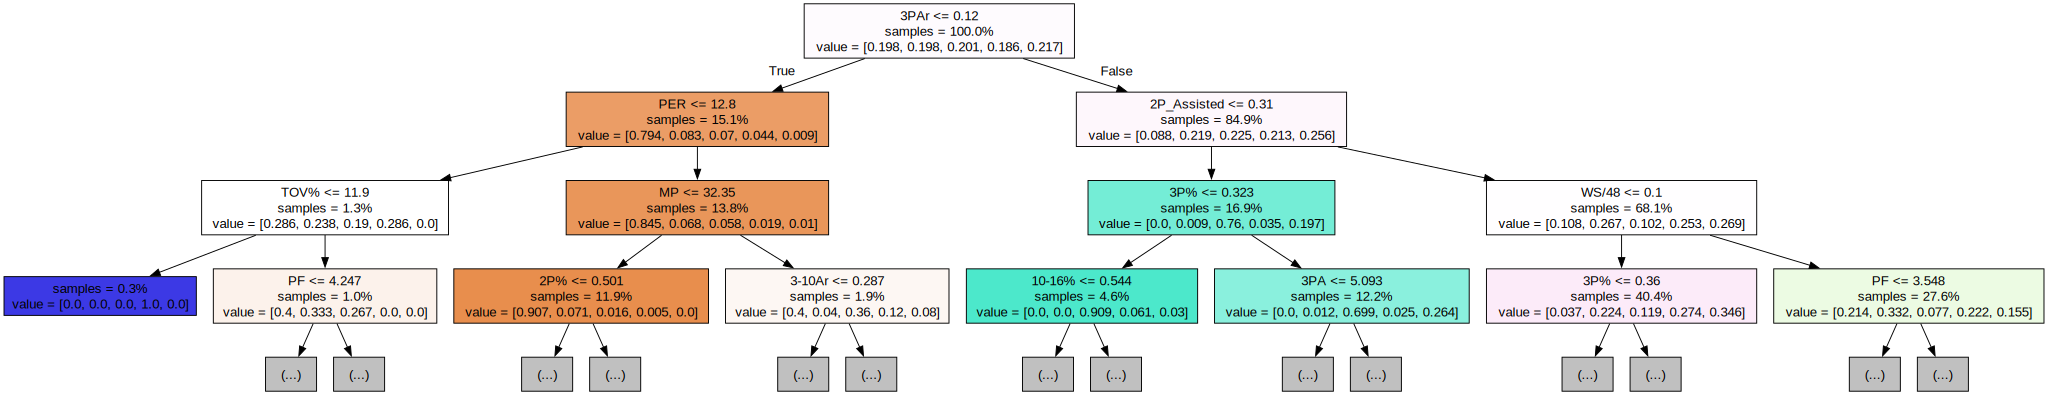

In [21]:
for i in range(3):
    tree = rf.estimators_[i]
    dot_data = export_graphviz(tree,
                               feature_names=X_train.columns,  
                               filled=True,  
                               max_depth=3, 
                               impurity=False, 
                               proportion=True)
    graph = graphviz.Source(dot_data)
    display(graph)

## Repeat the random forest process, but with data from the early 2000s

## Feature selection, splitting into training/testing

In [22]:
old_df = pre_process(range(2000, 2006))

In [23]:
features = old_df.loc[:, ~old_df.columns.isin(["Player", "Pos", "Tm"])]
target = old_df['Pos']

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.2, random_state=42)

## Randomly select better parameters for Random Forest and fit the data

In [24]:
rf = random_forest_classify(X_train, y_train)

In [25]:
y_pred = rf.predict(X_test)

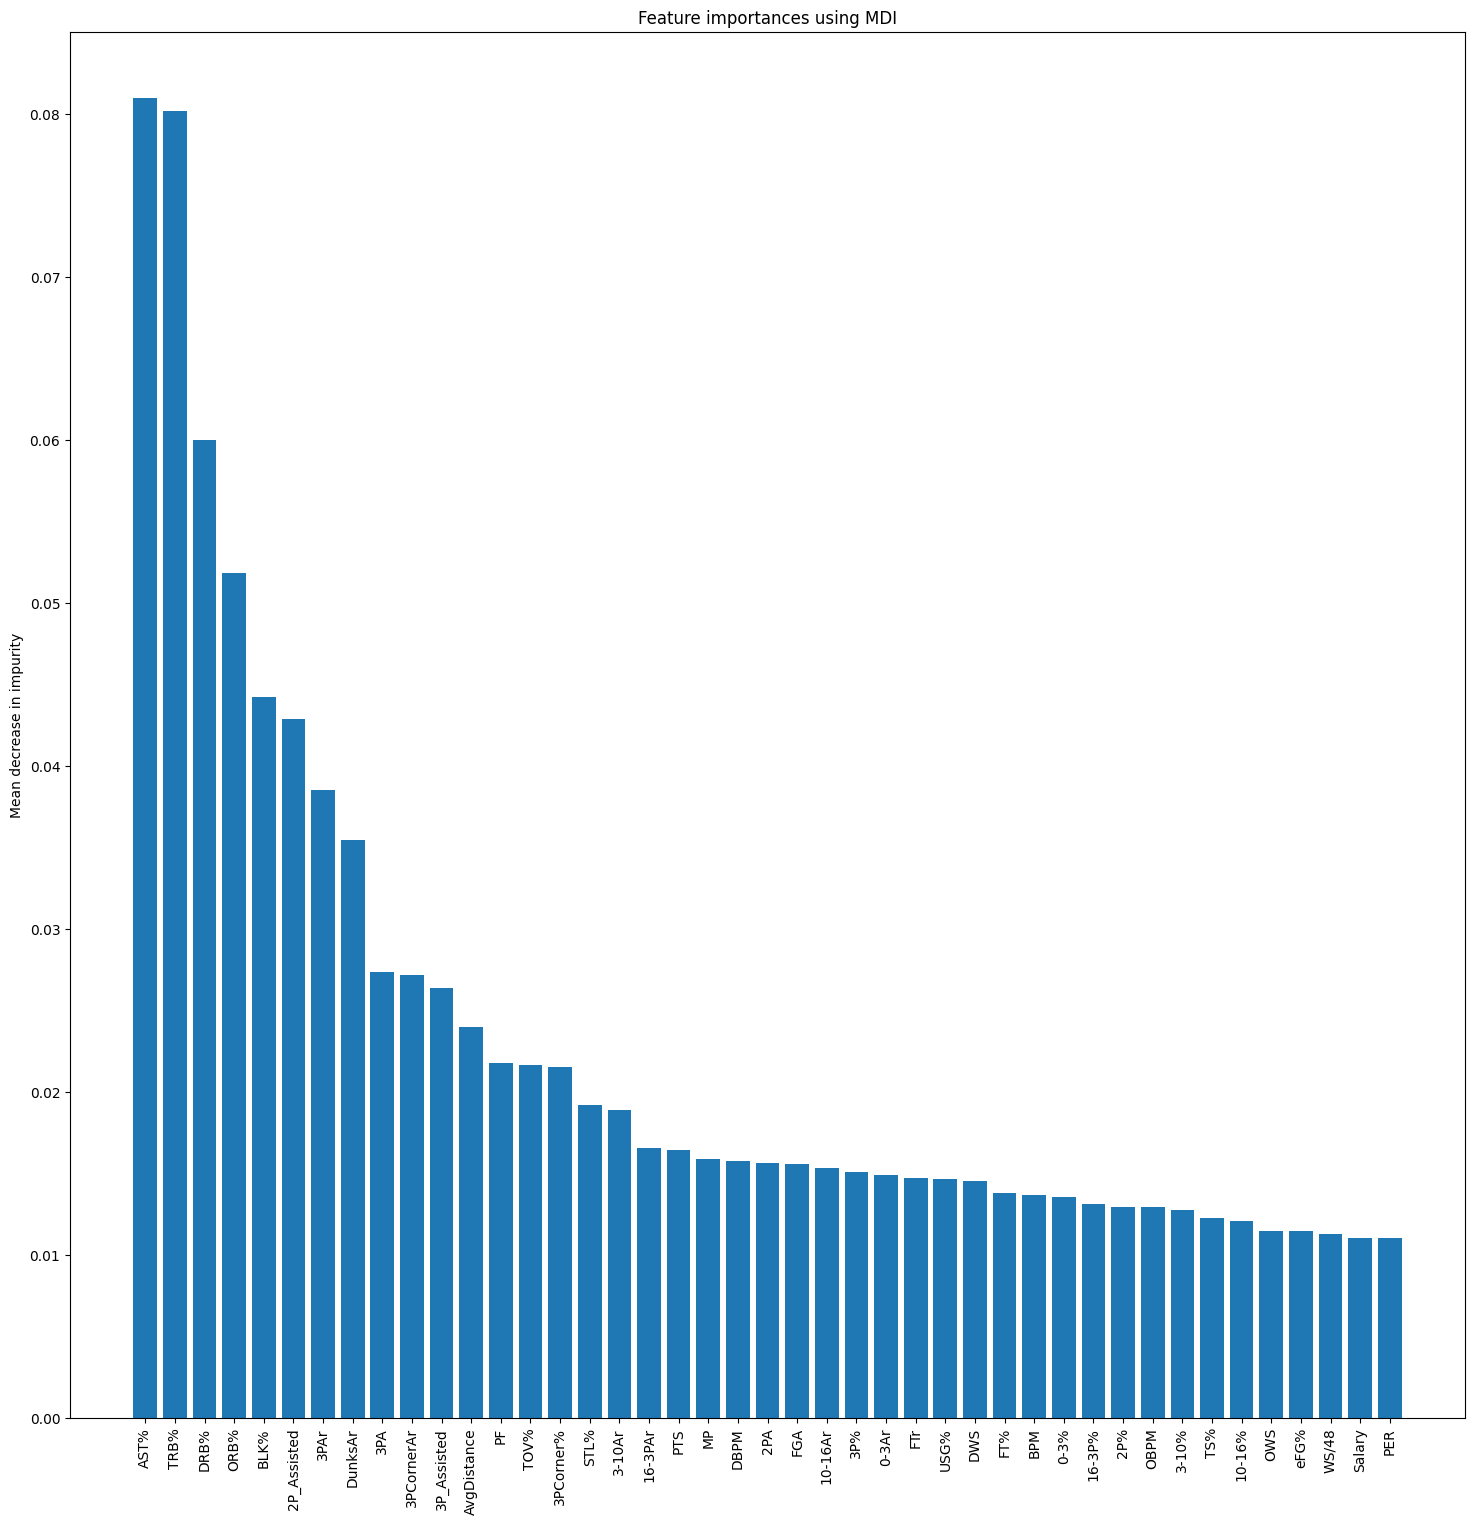

In [26]:
plot_feature_importances(rf.feature_importances_, rf.estimators_, [c for c in df.columns if c not in ['Player', 'Pos', 'Tm']])

Text(0.5, 0, 'Feature')

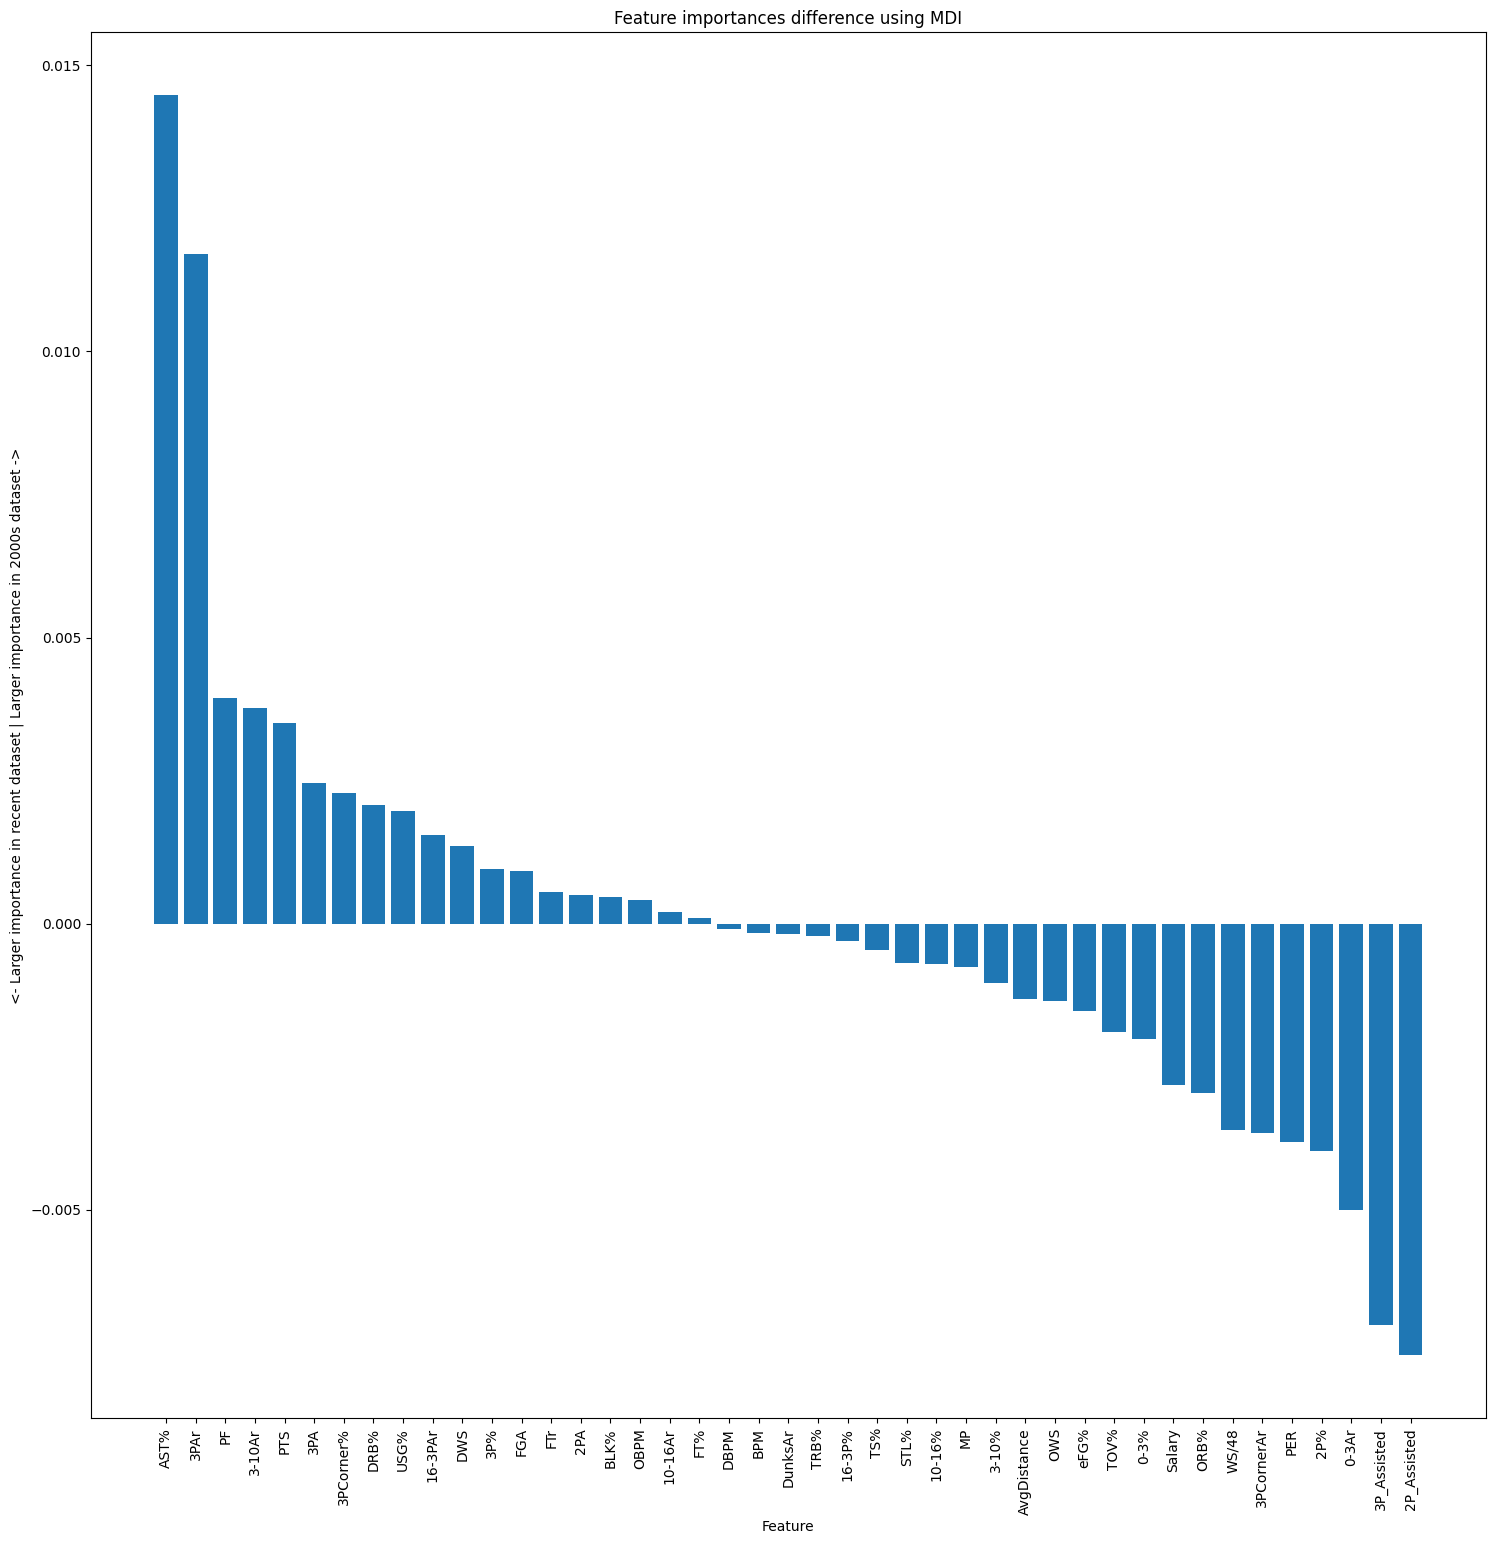

In [27]:
fis = pd.Series(rf.feature_importances_ - fi, index=[c for c in df.columns if c not in ['Player', 'Pos', 'Tm']]).sort_values(ascending=False)
fig, ax = plt.subplots(figsize=(18, 18))
ax.bar(fis.index, fis)
ax.tick_params('x', labelrotation=90)
ax.set_title("Feature importances difference using MDI")
ax.set_ylabel("<- Larger importance in recent dataset | Larger importance in 2000s dataset ->")
ax.set_xlabel("Feature")

## Evaluating Random Forest results with Confusion Matrix and accuracy score

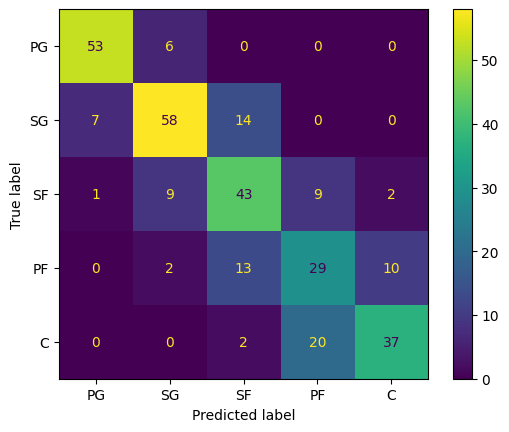

In [28]:
labels = ["PG", "SG", "SF", "PF", "C"]
cm = confusion_matrix(y_test, y_pred, labels=labels)
ConfusionMatrixDisplay(cm, display_labels=labels).plot()

In [29]:
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.6984126984126984

In [30]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           C       0.76      0.63      0.69        59
          PF       0.50      0.54      0.52        54
          PG       0.87      0.90      0.88        59
          SF       0.60      0.67      0.63        64
          SG       0.77      0.73      0.75        79

    accuracy                           0.70       315
   macro avg       0.70      0.69      0.69       315
weighted avg       0.71      0.70      0.70       315



In [31]:
prob_matrix = calculate_probability_matrix(cm)

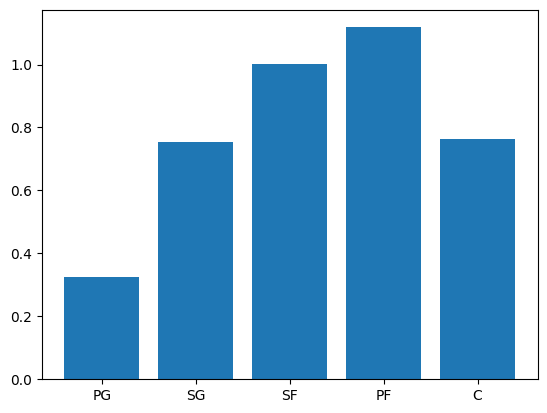

In [32]:
entropies = entropy_by_position(POSITIONS, prob_matrix)
plot_entropies_bar(entropies)
entropies_df['Old_Old'] = entropies

## Visualize trees from random forest with Graphviz

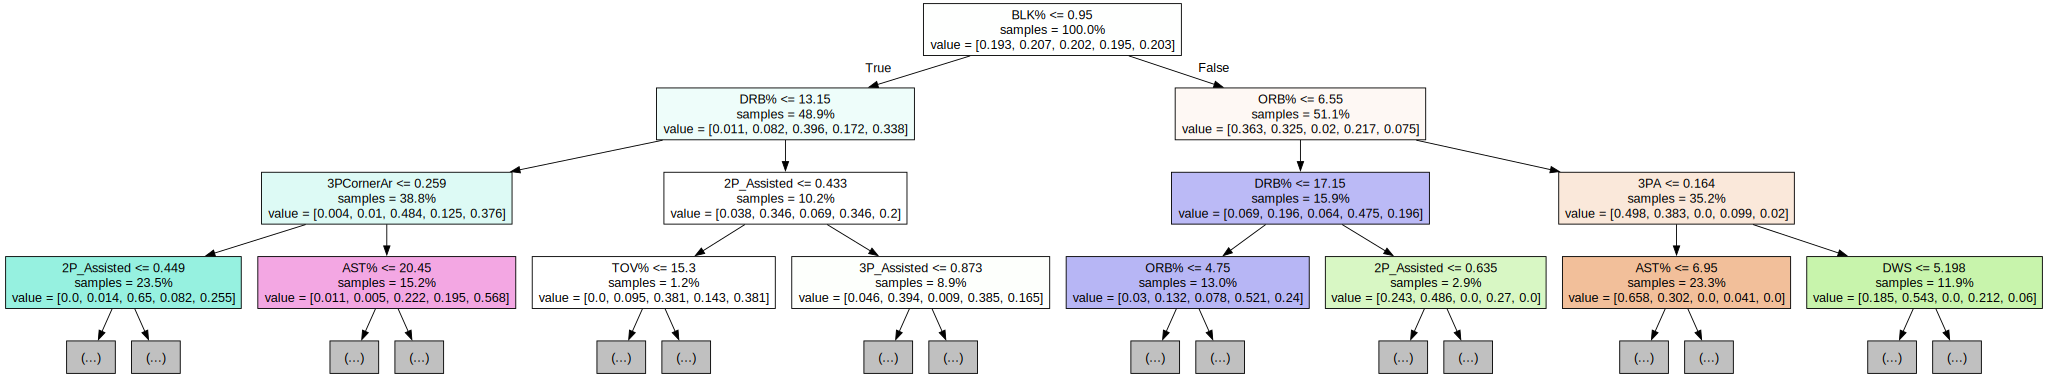

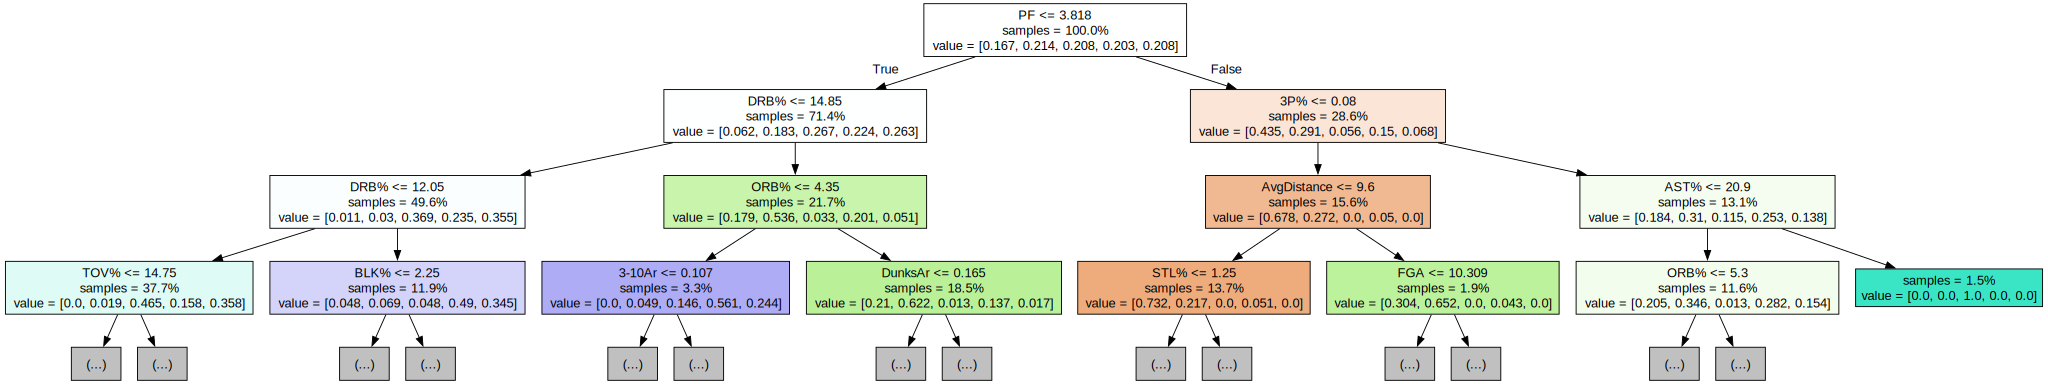

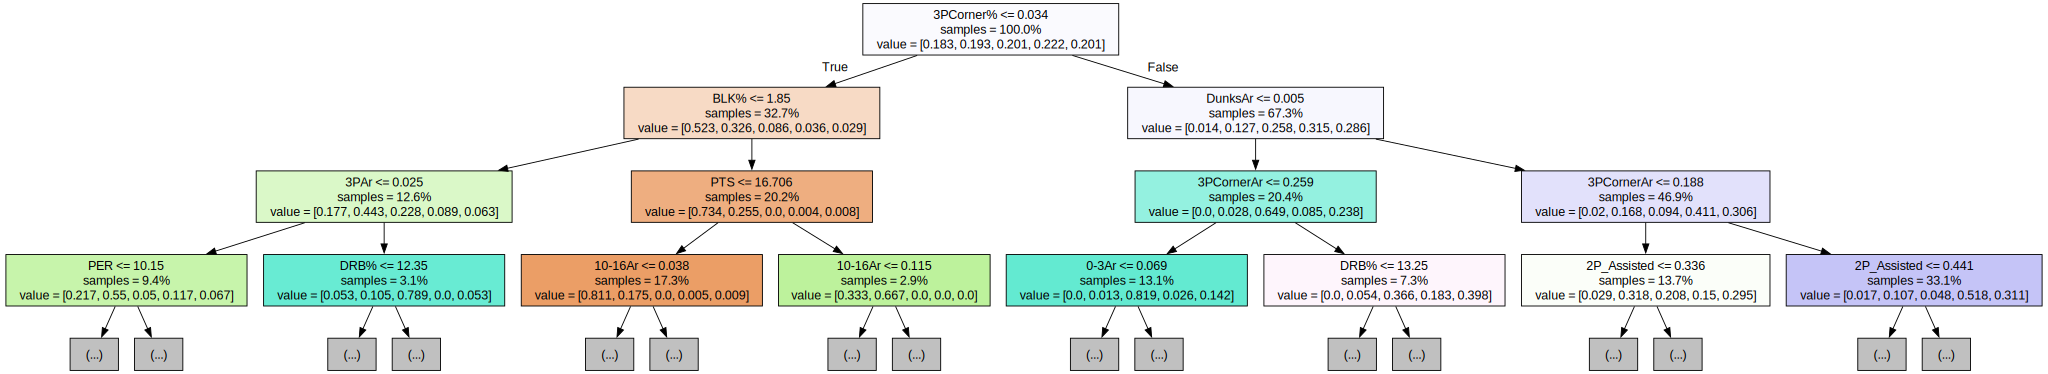

In [33]:
for i in range(3):
    tree = rf.estimators_[i]
    dot_data = export_graphviz(tree,
                               feature_names=X_train.columns,  
                               filled=True,  
                               max_depth=3, 
                               impurity=False, 
                               proportion=True)
    graph = graphviz.Source(dot_data)
    display(graph)

## Repeat the random forest process, but training with recent seasons and predicting old ones

## Splitting into training/testing

In [34]:
features = df.loc[:, ~df.columns.isin(["Player", "Pos", "Tm"])]
target = df['Pos']

old_features = old_df.loc[:, ~old_df.columns.isin(["Player", "Pos", "Tm"])]
old_target = old_df['Pos']

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.2, random_state=42)
old_X_train, old_X_test, old_y_train, old_y_test = train_test_split(old_features, old_target, test_size = 0.2, random_state=42)

## Randomly select better parameters for Random Forest and fit the data

In [35]:
rf = random_forest_classify(X_train, y_train)

In [36]:
y_pred = rf.predict(old_X_test)

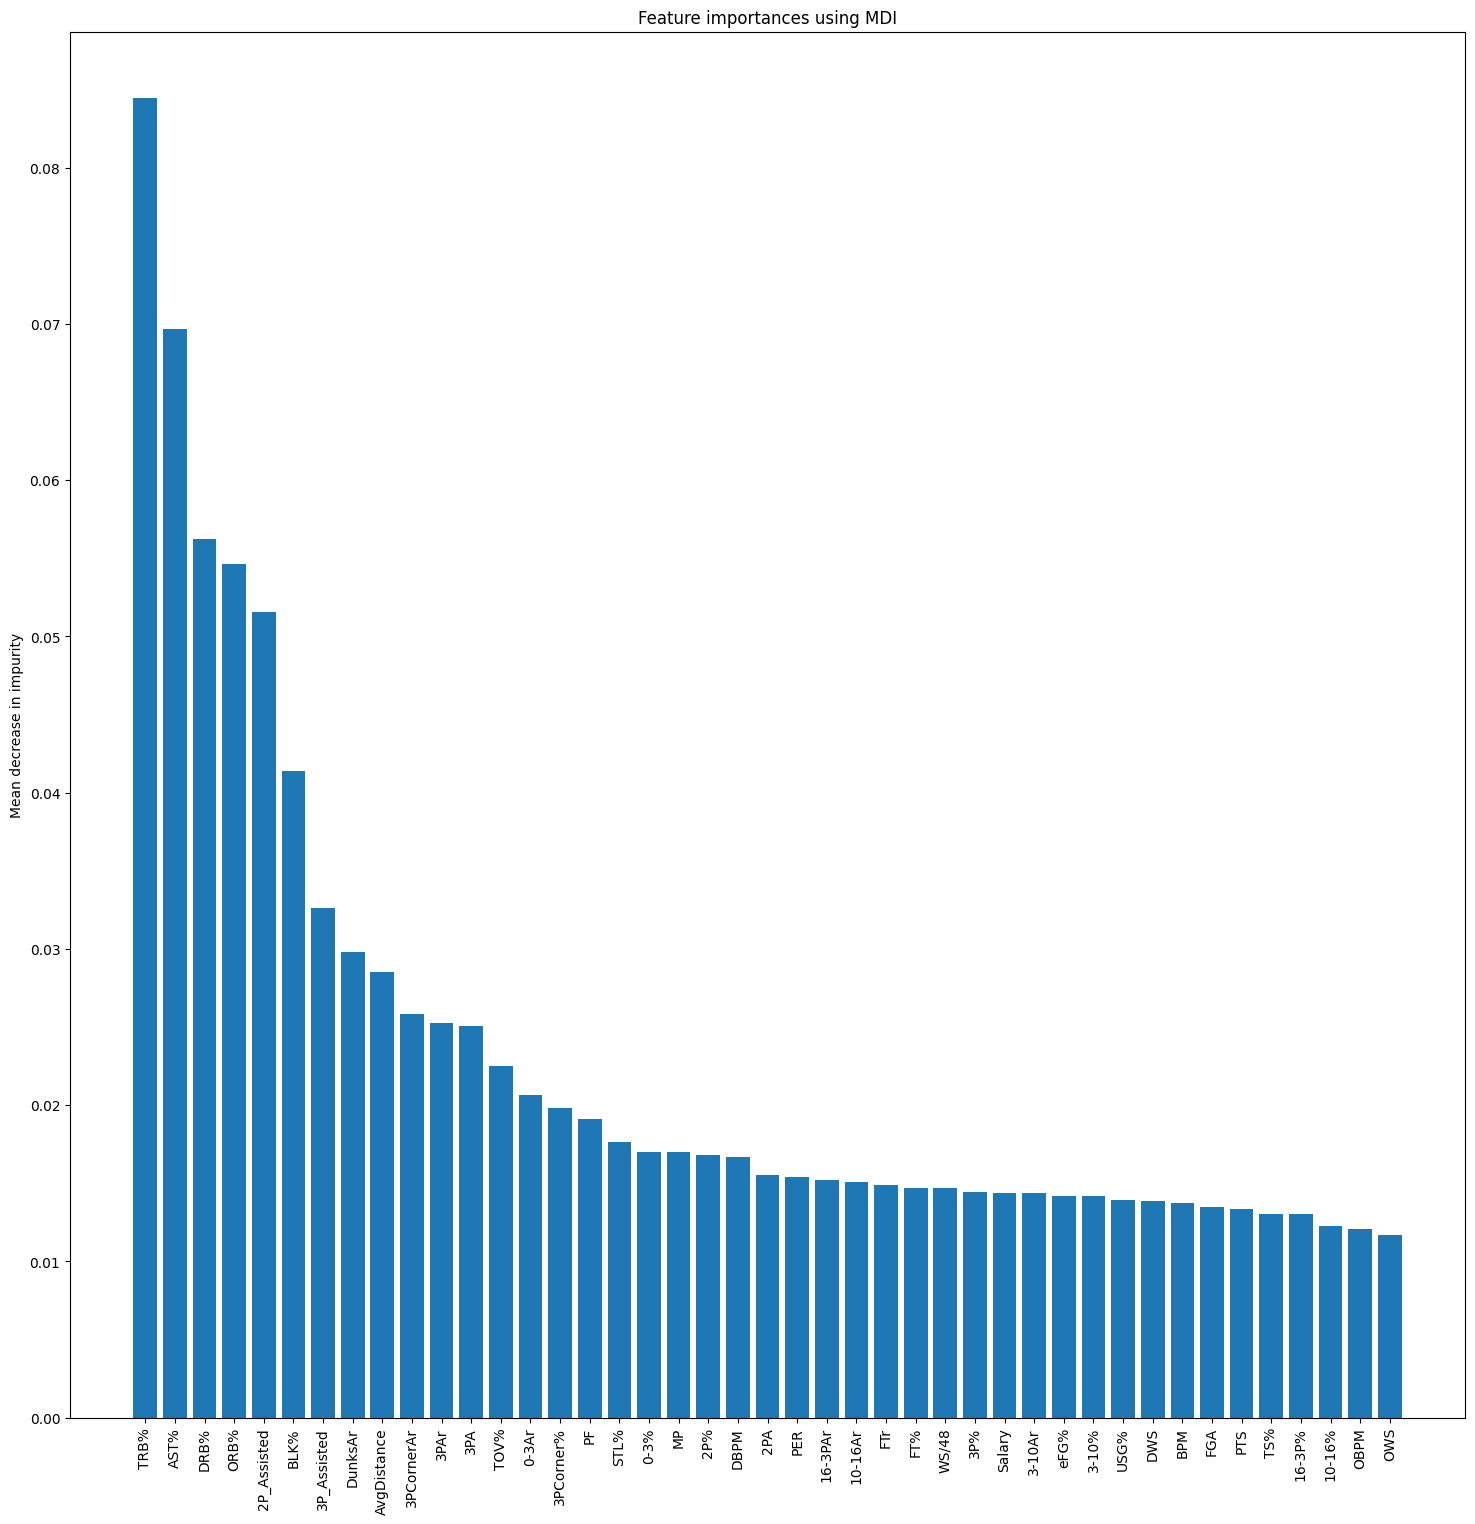

In [37]:
plot_feature_importances(rf.feature_importances_, rf.estimators_, [c for c in df.columns if c not in ['Player', 'Pos', 'Tm']])

## Evaluating Random Forest results with Confusion Matrix and accuracy score

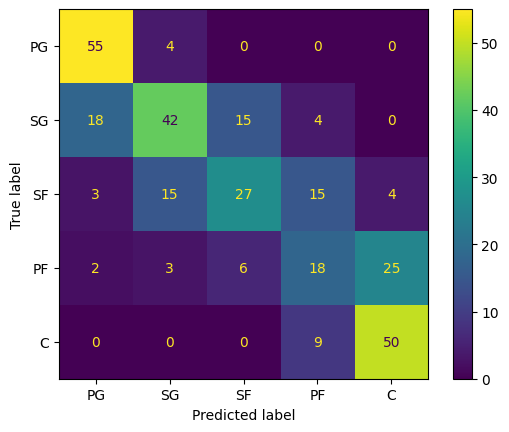

In [38]:
labels = ["PG", "SG", "SF", "PF", "C"]
cm = confusion_matrix(old_y_test, y_pred, labels=labels)
ConfusionMatrixDisplay(cm, display_labels=labels).plot()

In [39]:
accuracy = accuracy_score(old_y_test, y_pred)
accuracy

0.6095238095238096

In [40]:
print(classification_report(old_y_test, y_pred))

              precision    recall  f1-score   support

           C       0.63      0.85      0.72        59
          PF       0.39      0.33      0.36        54
          PG       0.71      0.93      0.80        59
          SF       0.56      0.42      0.48        64
          SG       0.66      0.53      0.59        79

    accuracy                           0.61       315
   macro avg       0.59      0.61      0.59       315
weighted avg       0.60      0.61      0.59       315



In [41]:
prob_matrix = calculate_probability_matrix(cm)

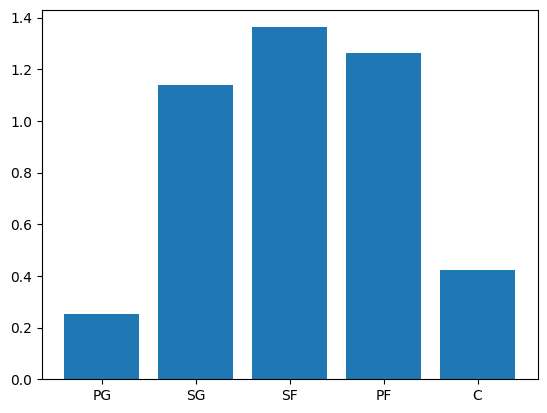

In [42]:
entropies = entropy_by_position(POSITIONS, prob_matrix)
plot_entropies_bar(entropies)
entropies_df['Mod_Old'] = entropies

## Visualize trees from random forest with Graphviz

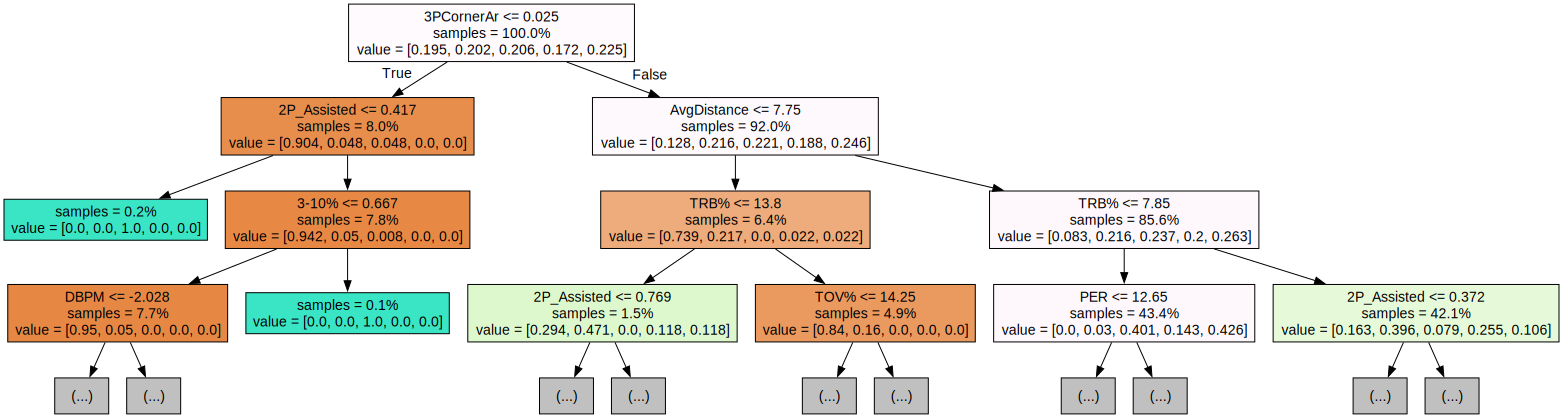

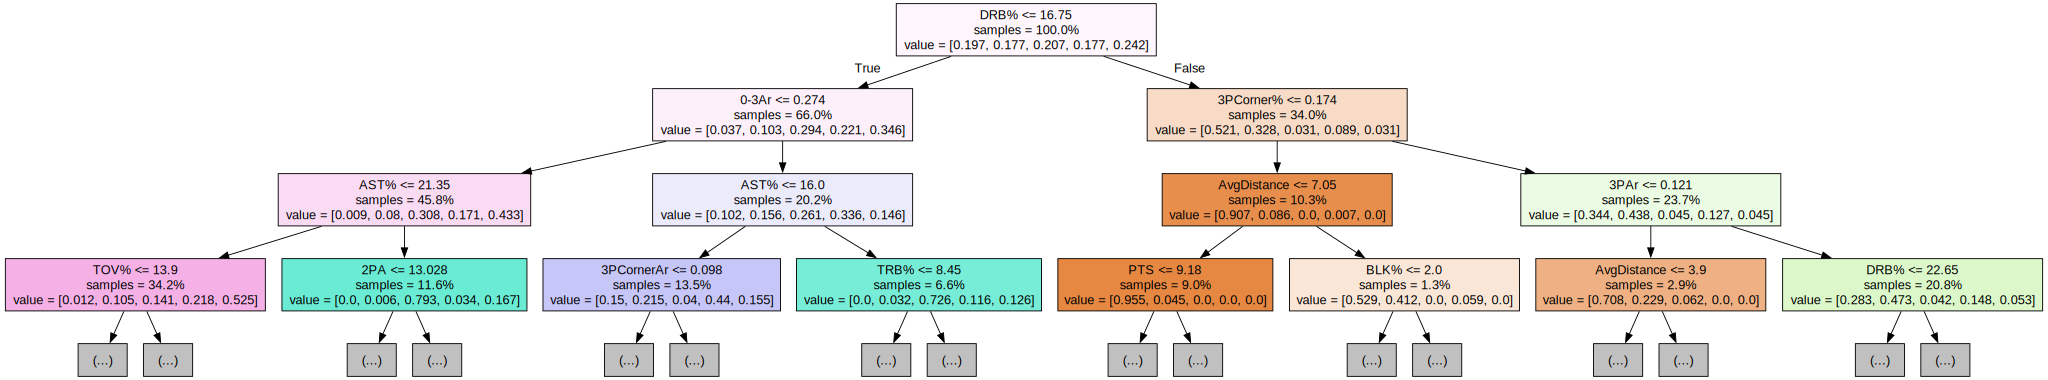

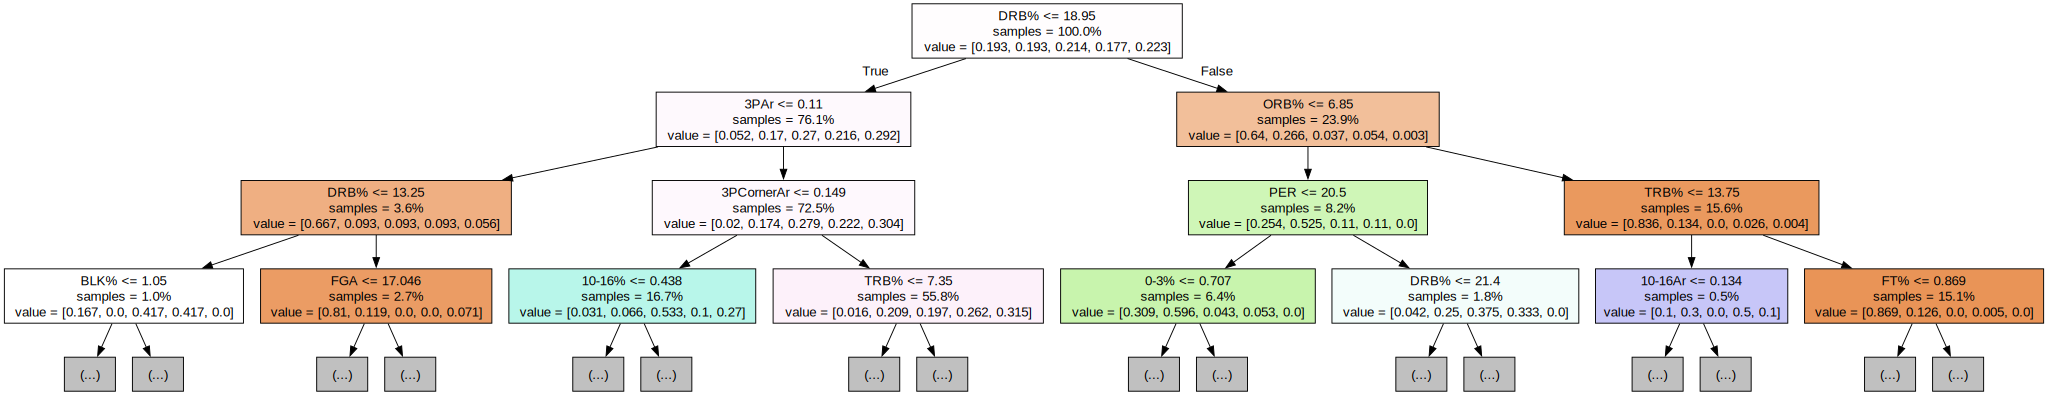

In [43]:
for i in range(3):
    tree = rf.estimators_[i]
    dot_data = export_graphviz(tree,
                               feature_names=X_train.columns,  
                               filled=True,  
                               max_depth=3, 
                               impurity=False, 
                               proportion=True)
    graph = graphviz.Source(dot_data)
    display(graph)

## Repeat the random forest process, but training with old seasons and predicting recent ones

## Randomly select better parameters for Random Forest and fit the data

In [44]:
rf = random_forest_classify(old_X_train, old_y_train)

In [45]:
y_pred = rf.predict(X_test)

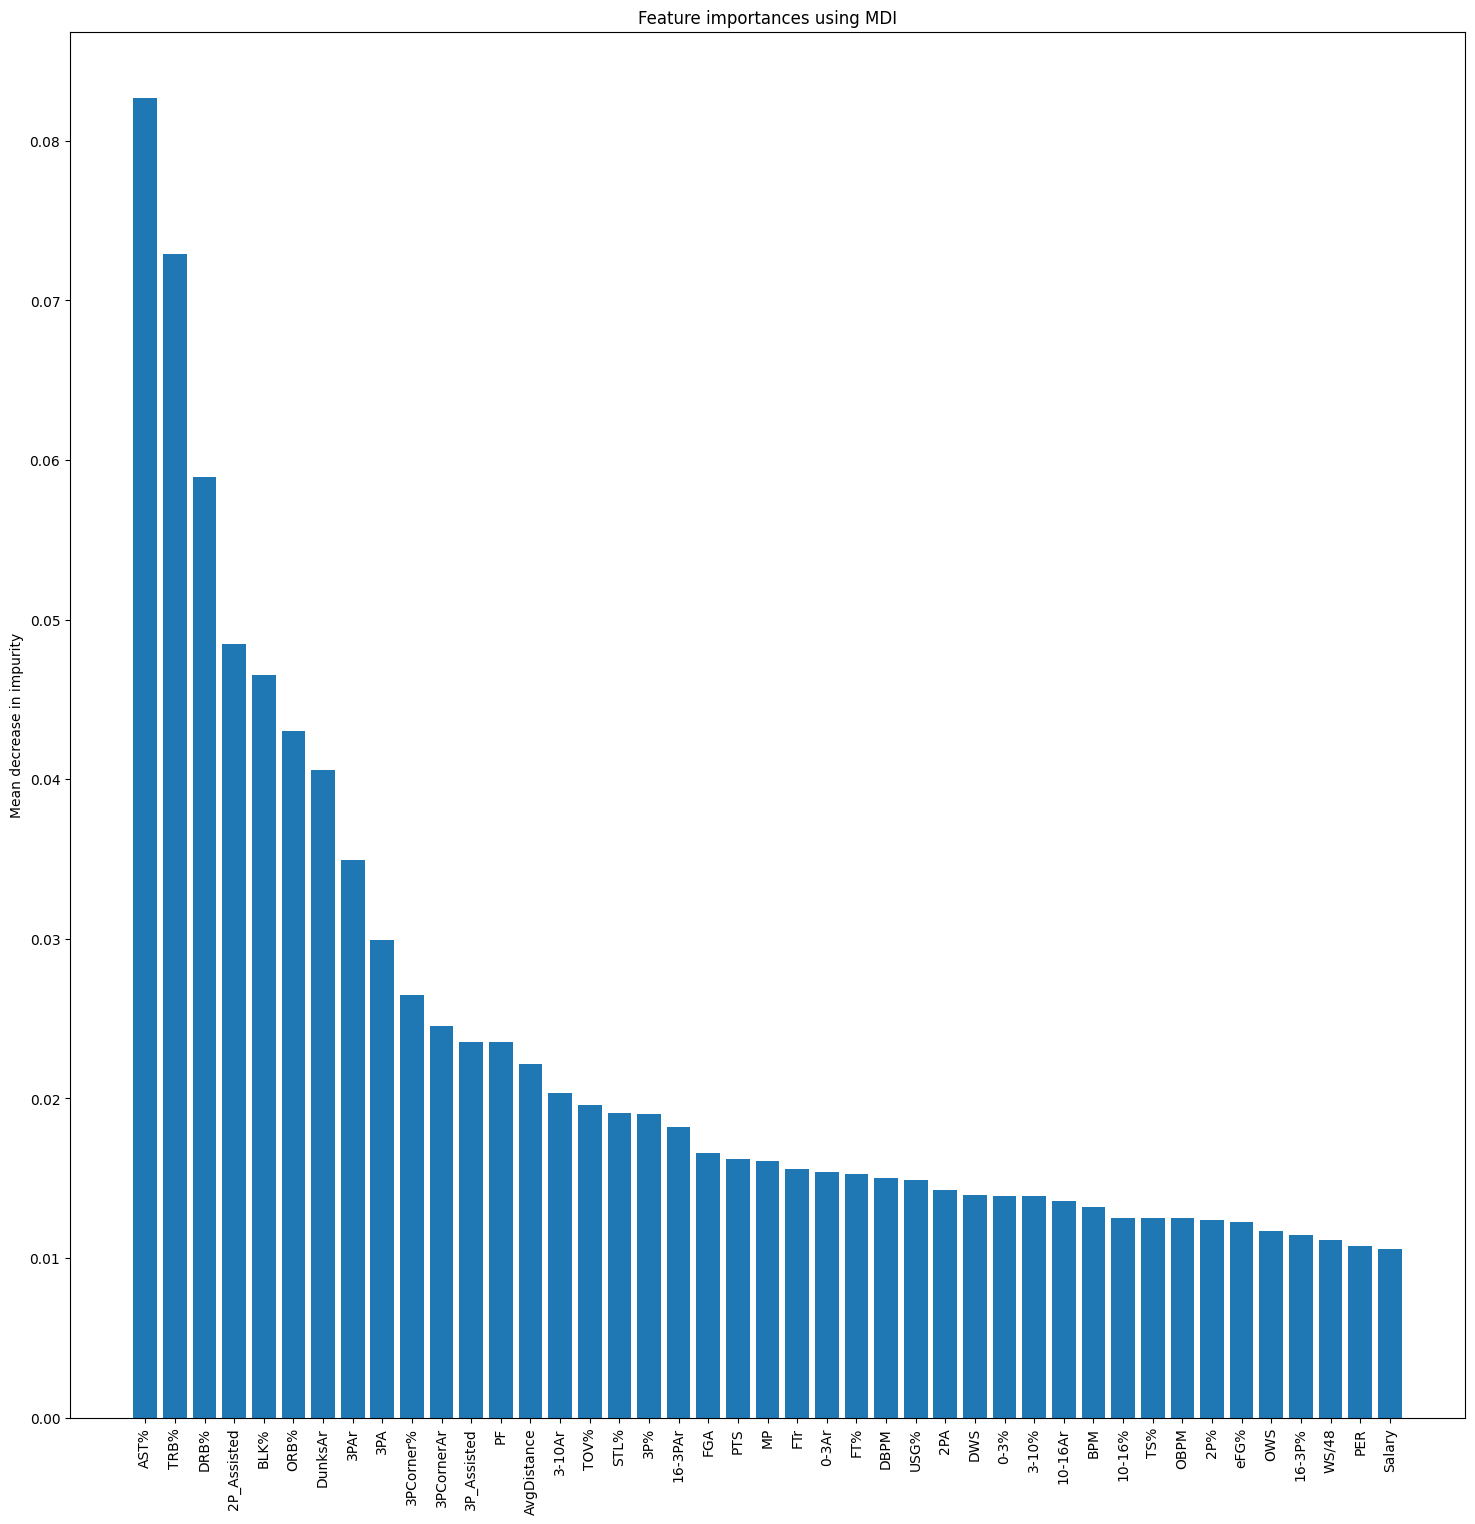

In [46]:
plot_feature_importances(rf.feature_importances_, rf.estimators_, [c for c in df.columns if c not in ['Player', 'Pos', 'Tm']])

## Evaluating Random Forest results with Confusion Matrix and accuracy score

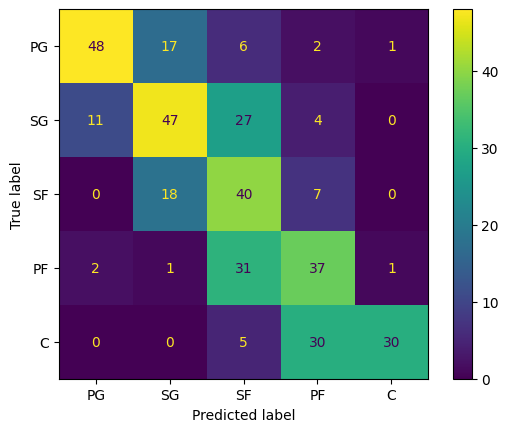

In [47]:
labels = ["PG", "SG", "SF", "PF", "C"]
cm = confusion_matrix(y_test, y_pred, labels=labels)
ConfusionMatrixDisplay(cm, display_labels=labels).plot()

In [48]:
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.5534246575342465

In [49]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           C       0.94      0.46      0.62        65
          PF       0.46      0.51      0.49        72
          PG       0.79      0.65      0.71        74
          SF       0.37      0.62      0.46        65
          SG       0.57      0.53      0.55        89

    accuracy                           0.55       365
   macro avg       0.62      0.55      0.56       365
weighted avg       0.62      0.55      0.57       365



In [50]:
prob_matrix = calculate_probability_matrix(cm)

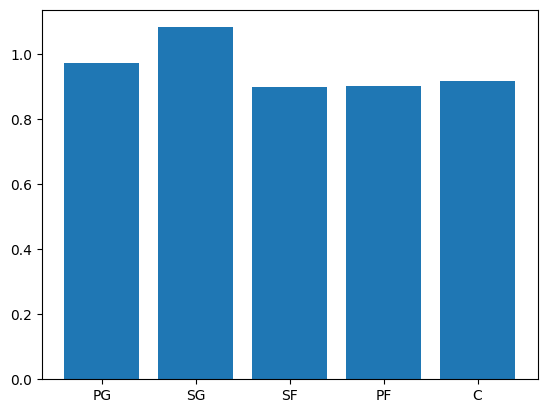

In [51]:
entropies = entropy_by_position(POSITIONS, prob_matrix)
plot_entropies_bar(entropies)
entropies_df['Old_Mod'] = entropies

## Visualize trees from random forest with Graphviz

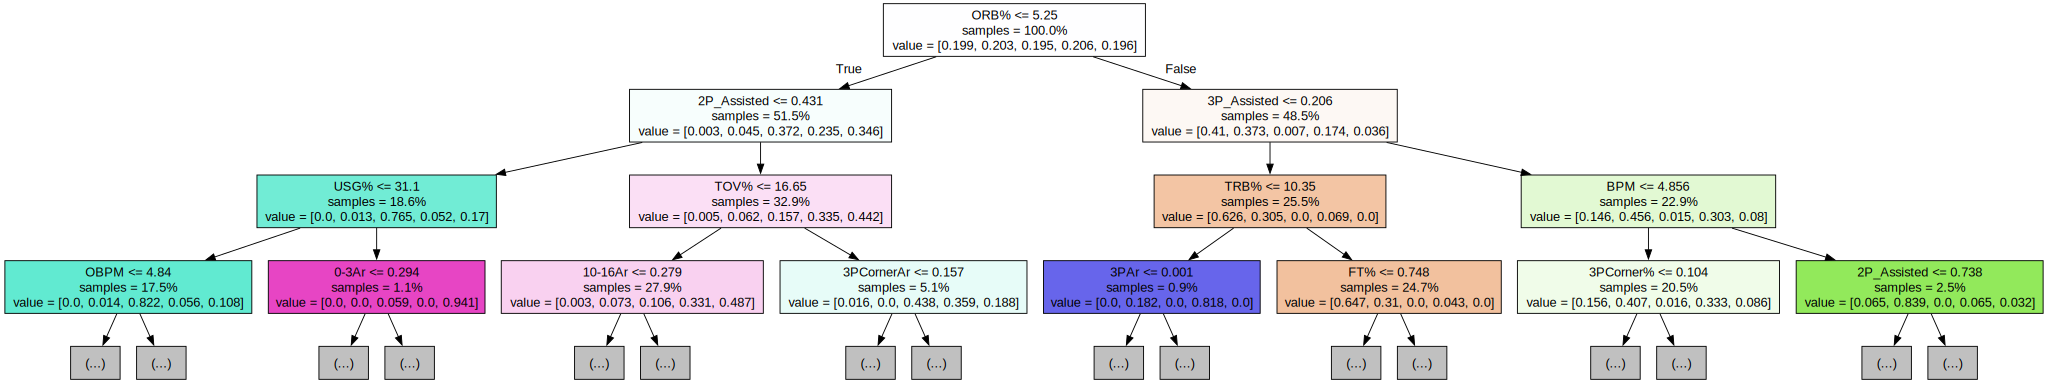

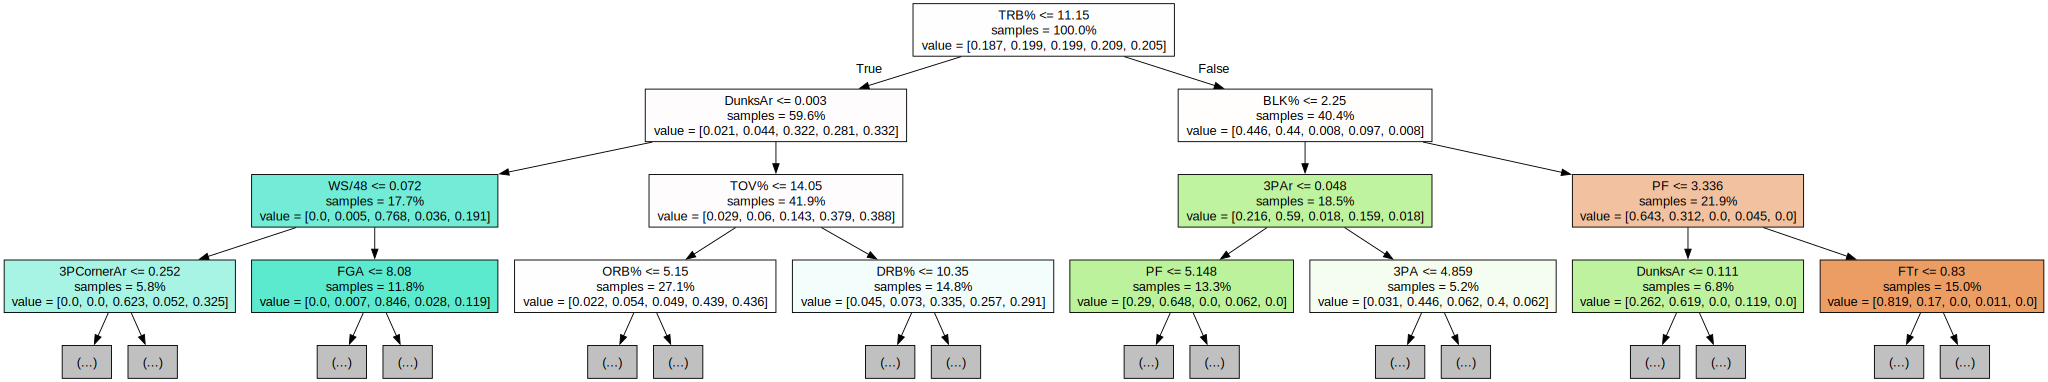

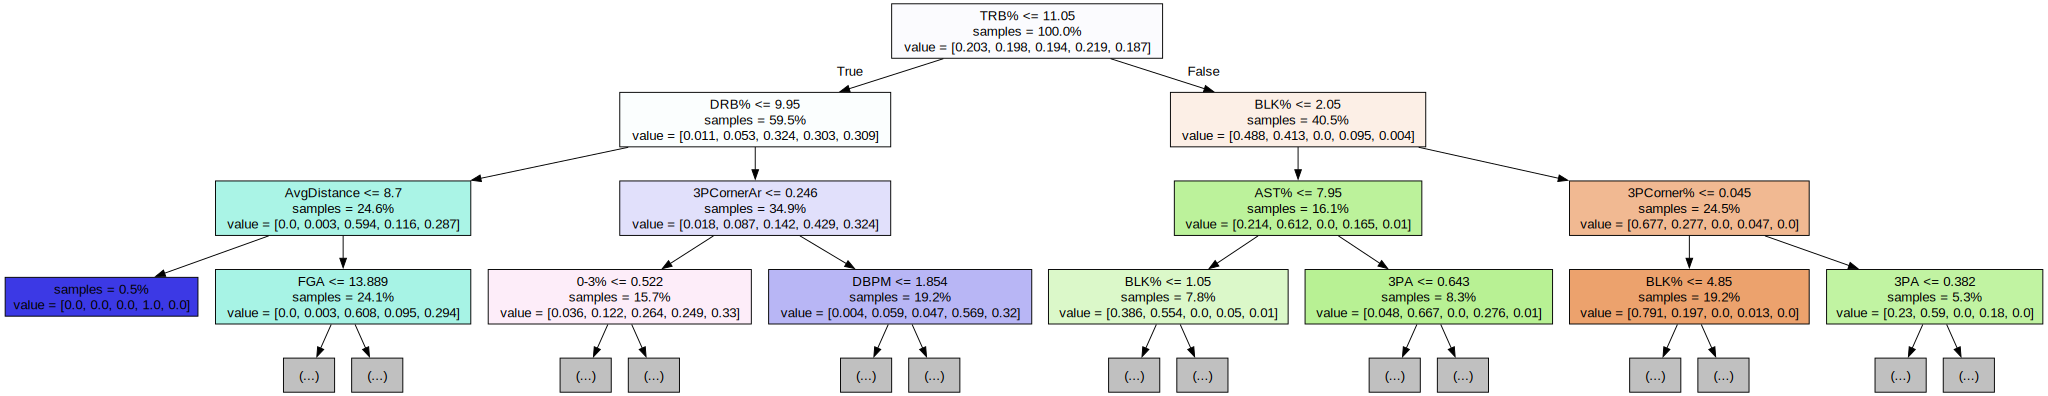

In [52]:
for i in range(3):
    tree = rf.estimators_[i]
    dot_data = export_graphviz(tree,
                               feature_names=X_train.columns,  
                               filled=True,  
                               max_depth=3, 
                               impurity=False, 
                               proportion=True)
    graph = graphviz.Source(dot_data)
    display(graph)

## Repeat the random forest process, with the first seasons with the 3-point line

In [53]:
first_dfs = []

In [54]:
for season in range(1980,1986):
    first_year, second_year = format_season(season)
    player_data = pd.read_csv(f"DataCollection/Player_Stats/player_stats_{first_year}-{second_year}.csv")    
    player_data = player_data.fillna(0)
    player_data = player_data[(player_data["MP"] > 15) & (player_data["G"] >= 30)]
    player_data = player_data.sort_values(by=['G'], ascending=False)
    player_data = player_data[player_data["Tm"] != "TOT"]
    player_data = player_data.drop_duplicates(subset ="Player",keep = "first")
    player_data.reset_index(inplace=True)
    player_data.drop(columns=['index'], inplace=True)
    
    first_dfs.append(player_data)

In [55]:
first_df = first_dfs[0]
for i in range(1, len(first_dfs)):
    first_df = pd.concat([first_df, first_dfs[i]])
    
first_df.reset_index(inplace=True)
first_df.drop('index', axis=1, inplace=True)

In [56]:
first_df = pre_process(range(1980, 1988))

## Splitting into training/testing

In [57]:
features = first_df.loc[:, ~first_df.columns.isin(["Player", "Pos", "Tm"])]
target = first_df['Pos']

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.2, random_state=42)

## Randomly select better parameters for Random Forest and fit the data

In [58]:
rf = random_forest_classify(X_train, y_train)

In [59]:
y_pred = rf.predict(X_test)

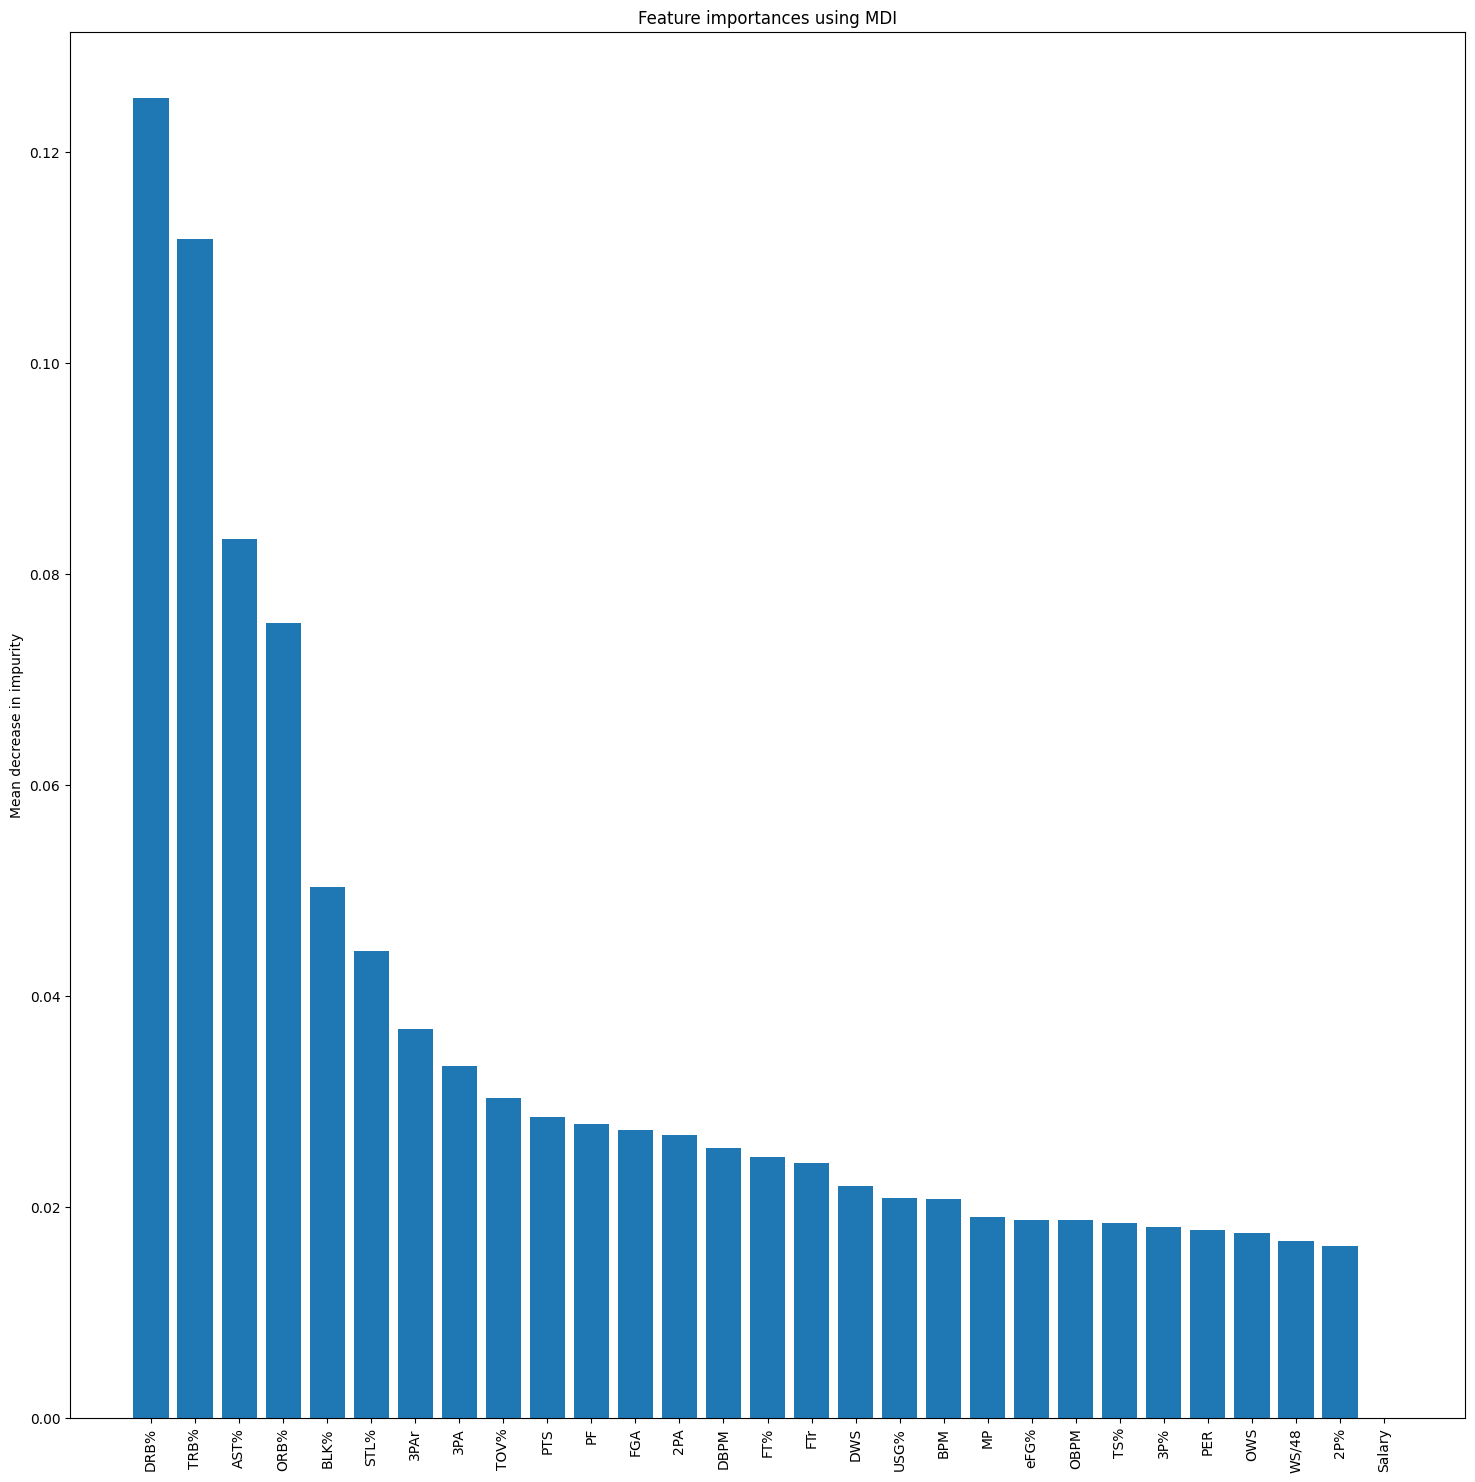

In [60]:
plot_feature_importances(rf.feature_importances_, rf.estimators_, [c for c in first_df.columns if c not in ['Player', 'Pos', 'Tm']])

## Evaluating Random Forest results with Confusion Matrix and accuracy score

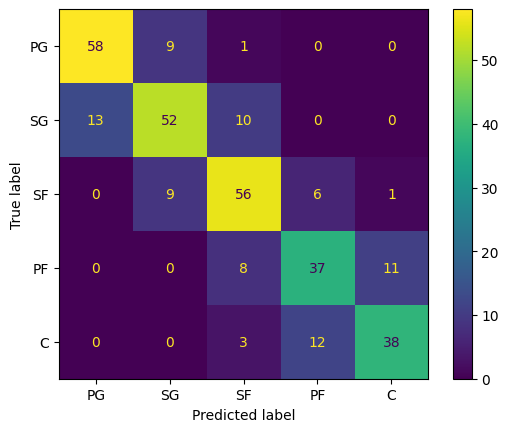

In [61]:
labels = ["PG", "SG", "SF", "PF", "C"]
cm = confusion_matrix(y_test, y_pred, labels=labels)
ConfusionMatrixDisplay(cm, display_labels=labels).plot()

In [62]:
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.7438271604938271

In [63]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           C       0.76      0.72      0.74        53
          PF       0.67      0.66      0.67        56
          PG       0.82      0.85      0.83        68
          SF       0.72      0.78      0.75        72
          SG       0.74      0.69      0.72        75

    accuracy                           0.74       324
   macro avg       0.74      0.74      0.74       324
weighted avg       0.74      0.74      0.74       324



In [64]:
prob_matrix = calculate_probability_matrix(cm)

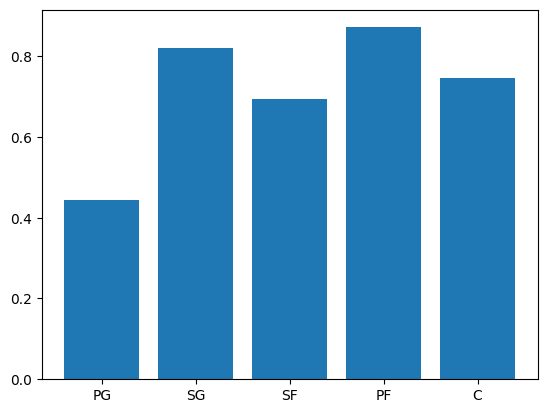

In [65]:
entropies = entropy_by_position(POSITIONS, prob_matrix)
plot_entropies_bar(entropies)
entropies_df['1980s'] = entropies

## Visualize trees from random forest with Graphviz

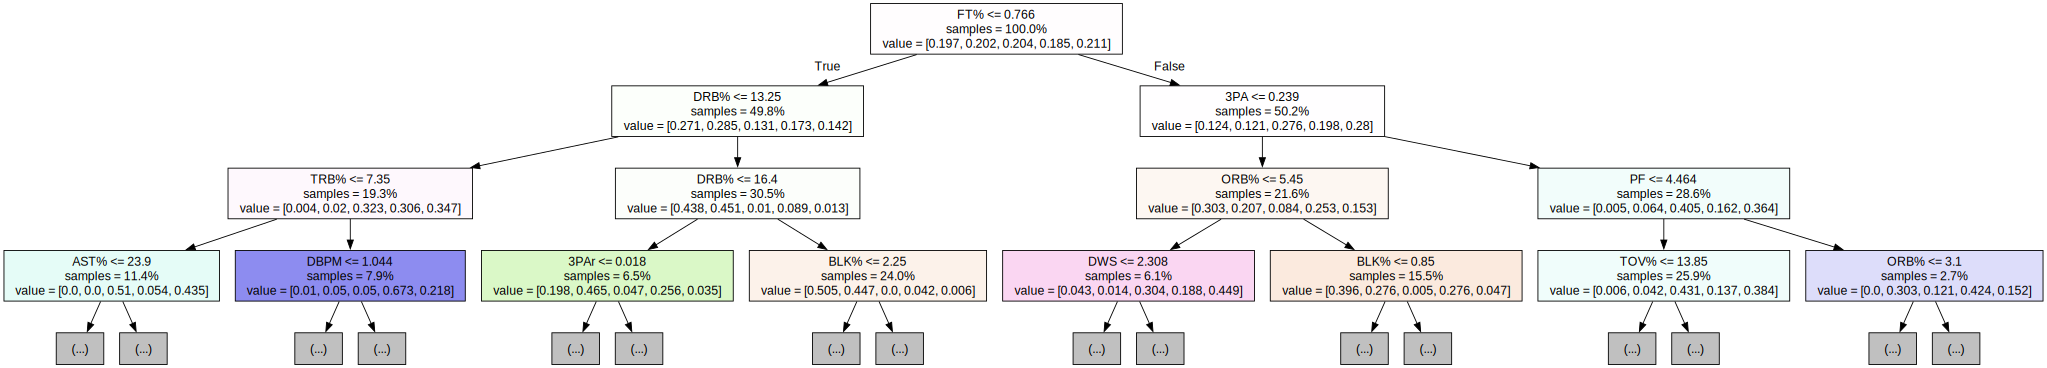

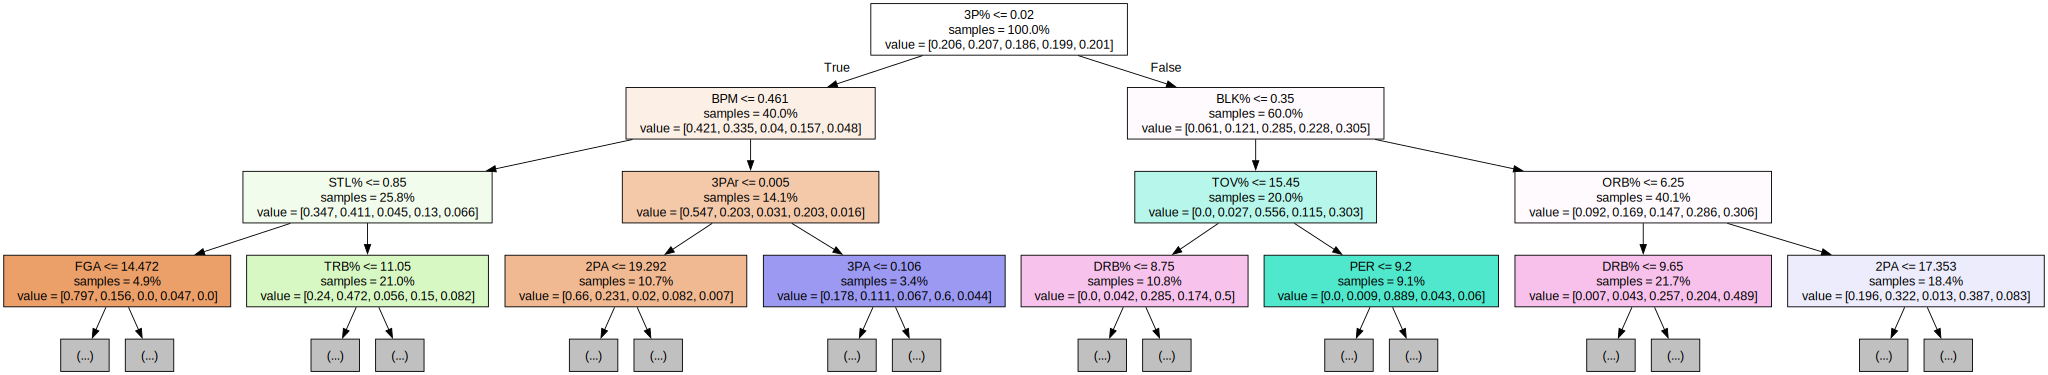

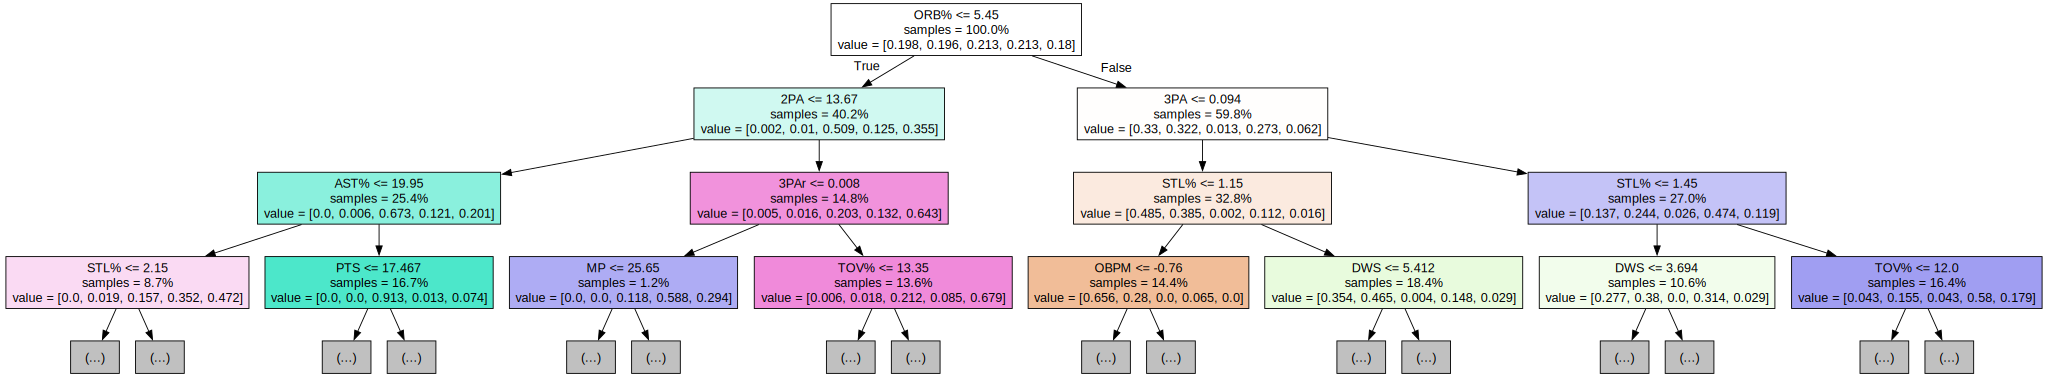

In [66]:
for i in range(3):
    tree = rf.estimators_[i]
    dot_data = export_graphviz(tree,
                               feature_names=X_train.columns,  
                               filled=True,  
                               max_depth=3, 
                               impurity=False, 
                               proportion=True)
    graph = graphviz.Source(dot_data)
    display(graph)

In [70]:
entropies_df
entropies_df['Positions'] = entropies_df.index

<Axes: xlabel='Positions'>

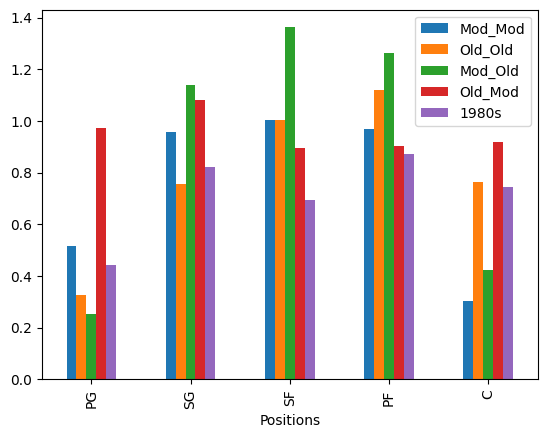

In [72]:
entropies_df.plot(x='Positions', kind='bar')